In [69]:
%pylab inline
import pandas as pd
import mdtraj as md

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:

top_h_unbound = md.load('H-unbound.pdb')
top_h_bound = md.load('H-bound.pdb')

top_r2_unbound = md.load('r2_unbound.pdb')
top_r2_bound = md.load('r2_bound.pdb')

In [4]:
from itertools import combinations

def best_hummer_q(traj, native, index):    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.6  # nanometers
    
    # get the indices of all of the heavy atoms
#     heavy = native.topology.select_atom_indices('heavy')
    heavy = index
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
#     print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q

In [5]:
temps = ('300k','373k','473k','573k')
print len(temps)

4


# H_unbound

In [61]:
h_unbound_trajs = []

n = 0

for t in temps:
    for i in ['','1','2']:
        traj = md.load_xtc('pro_xtc_10_21/H_unbound/H_unbound_pro_'+t+'.xtc', top=top_h_unbound)
        n += traj.n_frames
        h_unbound_trajs.append(traj)
       
print n

36012


In [7]:
h_v12 = top_h_unbound.topology.select('resid 101 to 171 and name CA')
print([atom for atom in top_h_unbound.topology.atoms if atom.index in h_v12])

[LYS102-CA, ILE103-CA, THR104-CA, MET105-CA, LYS106-CA, SER107-CA, THR108-CA, ASN109-CA, ASN110-CA, THR111-CA, ASN112-CA, THR113-CA, ASN114-CA, THR115-CA, SER116-CA, TRP117-CA, GLU118-CA, ARG119-CA, GLY120-CA, GLU121-CA, GLU122-CA, MET123-CA, LYS124-CA, ASN125-CA, CYS126-CA, SER127-CA, PHE128-CA, ASN129-CA, VAL130-CA, SER131-CA, SER132-CA, SER133-CA, VAL134-CA, ARG135-CA, ASP136-CA, LYS137-CA, MET138-CA, LYS139-CA, ARG140-CA, GLU141-CA, TYR142-CA, ALA143-CA, LEU144-CA, PHE145-CA, TYR146-CA, LYS147-CA, LEU148-CA, ASP149-CA, ILE150-CA, VAL151-CA, PRO152-CA, ILE153-CA, ASP154-CA, ASP155-CA, SER156-CA, ASN157-CA, SER158-CA, SER159-CA, SER160-CA, SER161-CA, ASN162-CA, TYR163-CA, SER164-CA, SER165-CA, TYR166-CA, ARG167-CA, LEU168-CA, ILE169-CA, ASN170-CA, CYS171-CA, ASN172-CA]


In [8]:
h_v3 = top_h_unbound.topology.select('resid 273 to 307 and name CA')
print([atom for atom in top_h_unbound.topology.atoms if atom.index in h_v3])

[PRO274-CA, ASN275-CA, ASN276-CA, ASN277-CA, THR278-CA, ARG279-CA, LYS280-CA, SER281-CA, ILE282-CA, PRO283-CA, ILE284-CA, GLY285-CA, PRO286-CA, GLY287-CA, ARG288-CA, ALA289-CA, PHE290-CA, TYR291-CA, THR292-CA, THR293-CA, GLY294-CA, ASP295-CA, ILE296-CA, ILE297-CA, GLY298-CA, ASP299-CA, ILE300-CA, ARG301-CA, GLN302-CA, ALA303-CA, HIS304-CA, CYS305-CA, ASN306-CA, ILE307-CA, SER308-CA]


In [9]:
h_b2 = top_h_unbound.topology.select('resid 88 to 90 and name CA')
print([atom for atom in top_h_unbound.topology.atoms if atom.index in h_b2])
h_b3 = top_h_unbound.topology.select('resid 175 to 176 and name CA')
print([atom for atom in top_h_unbound.topology.atoms if atom.index in h_b3])
h_b20 = top_h_unbound.topology.select('resid 391 to 393 and name CA')
print([atom for atom in top_h_unbound.topology.atoms if atom.index in h_b20])
h_b21 = top_h_unbound.topology.select('resid 400 to 402 and name CA')
print([atom for atom in top_h_unbound.topology.atoms if atom.index in h_b21])
h_b = concatenate((h_b2,h_b3,h_b20,h_b21))

[VAL89-CA, LYS90-CA, LEU91-CA]
[ILE176-CA, THR177-CA]
[ILE392-CA, VAL393-CA, ASN394-CA]
[LYS401-CA, ALA402-CA, MET403-CA]


In [62]:
h_q = pd.DataFrame()
h_q_v12 = pd.DataFrame()
h_q_v3 = pd.DataFrame()
h_q_b = pd.DataFrame()

for traj in h_unbound_trajs:
    q = best_hummer_q(traj, top_h_unbound, top_h_unbound.topology.select('name CA'))
    h_q = h_q.append(pd.Series(q), ignore_index=True)
    
    q = best_hummer_q(traj, top_h_unbound, h_v12)
    h_q_v12 = h_q_v12.append(pd.Series(q), ignore_index=True)
    
    q = best_hummer_q(traj, top_h_unbound, h_v3)
    h_q_v3 = h_q_v3.append(pd.Series(q), ignore_index=True)
    
    q = best_hummer_q(traj, top_h_unbound, h_b)
    h_q_b = h_q_b.append(pd.Series(q), ignore_index=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


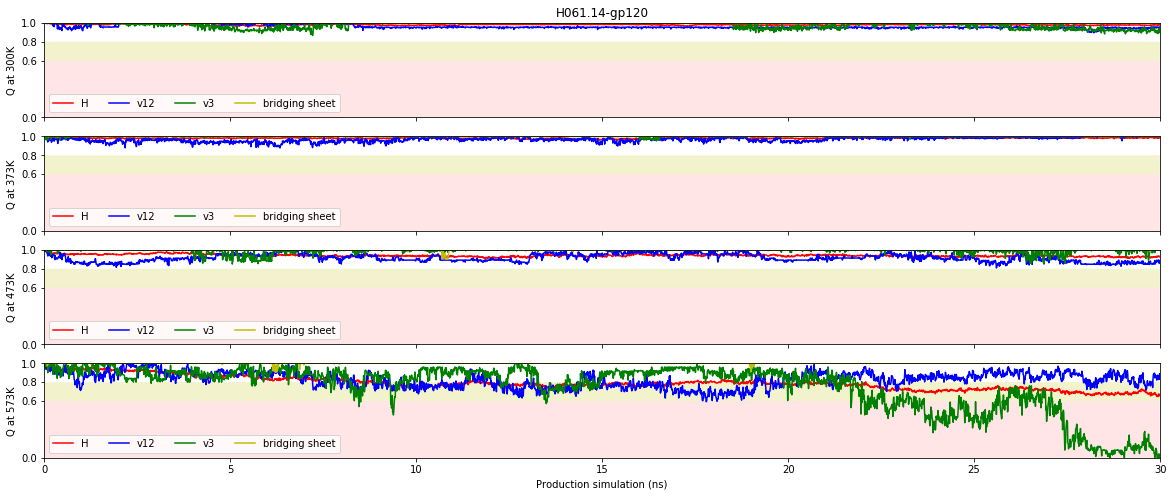

In [81]:
figure(figsize=(20,8))
for i,t in enumerate(temps): 
    subplot(4,1,i+1)
    if i ==0:
        title('H061.14-gp120')
    plot(h_q.iloc[i*3], 'r', label='H')
    plot(h_q_v12.iloc[i*3], 'b', label='v12')
    plot(h_q_v3.iloc[i*3], 'g', label='v3')
    plot(h_q_b.iloc[i*3], 'y', label='bridging sheet')
    fill_between(range(0,3000), 0.8, 0.6, facecolor='y', interpolate=True, alpha=0.2)
    fill_between(range(0,3000), 0.6, 0, facecolor='r', interpolate=True, alpha=0.1)
    xlim(0,3000)
    xticks([0,500,1000,1500,2000,2500,3000],[])
    ylim(0,1.0)
    ylabel('Q at '+t[:-1]+'K')
    yticks([0.0,0.6,0.8,1.0])
    legend(ncol=4,loc=3)
xticks([0,500,1000,1500,2000,2500,3000],['0','5','10','15','20','25','30'])
xlabel('Production simulation (ns)')
savefig('../imgs/fig 4/H.png',dpi=480,bbox_inches="tight")

# R2_unbound

In [53]:
r2_unbound_trajs = []

n = 0

for t in temps:
    for i in ['','1','2']:
        traj = md.load_xtc('pro_xtc_10_21/R2_unbound/R2_unbound_pro_'+t+'.xtc', top=top_r2_unbound)
        n += traj.n_frames
        r2_unbound_trajs.append(traj)
       
print n

36012


In [54]:
r2_v12 = top_r2_unbound.topology.select('resid 101 to 172 and name CA')
print([atom for atom in top_r2_unbound.topology.atoms if atom.index in r2_v12])

[ASP102-CA, LEU103-CA, ARG104-CA, ASN105-CA, THR106-CA, THR107-CA, ASN108-CA, THR109-CA, ASN110-CA, ASN111-CA, SER112-CA, THR113-CA, ASP114-CA, ASN115-CA, ASN116-CA, ASN117-CA, SER118-CA, ASN119-CA, SER120-CA, GLU121-CA, GLY122-CA, THR123-CA, ILE124-CA, LYS125-CA, GLY126-CA, GLY127-CA, GLU128-CA, MET129-CA, LYS130-CA, ASN131-CA, CYS132-CA, SER133-CA, PHE134-CA, ASN135-CA, ILE136-CA, ALA137-CA, THR138-CA, SER139-CA, ILE140-CA, GLY141-CA, ASP142-CA, LYS143-CA, MET144-CA, GLN145-CA, LYS146-CA, GLU147-CA, TYR148-CA, ALA149-CA, LEU150-CA, LEU151-CA, TYR152-CA, LYS153-CA, LEU154-CA, ASP155-CA, ILE156-CA, GLU157-CA, PRO158-CA, ILE159-CA, ASP160-CA, ASN161-CA, ASP162-CA, ASN163-CA, THR164-CA, SER165-CA, TYR166-CA, ARG167-CA, LEU168-CA, ILE169-CA, SER170-CA, CYS171-CA, ASN172-CA, THR173-CA]


In [55]:
r2_v3 = top_r2_unbound.topology.select('resid 273 to 307 and name CA')
print([atom for atom in top_r2_unbound.topology.atoms if atom.index in r2_v3])

[PRO274-CA, ASN275-CA, ASN276-CA, ASN277-CA, THR278-CA, ARG279-CA, LYS280-CA, SER281-CA, ILE282-CA, PRO283-CA, MET284-CA, GLY285-CA, PRO286-CA, GLY287-CA, ARG288-CA, ALA289-CA, PHE290-CA, TYR291-CA, THR292-CA, THR293-CA, GLY294-CA, GLN295-CA, ILE296-CA, ILE297-CA, GLY298-CA, ASP299-CA, ILE300-CA, ARG301-CA, GLN302-CA, ALA303-CA, HIS304-CA, CYS305-CA, ASN306-CA, ILE307-CA, SER308-CA]


In [56]:
r2_b2 = top_r2_unbound.topology.select('resid 88 to 90 and name CA')
print([atom for atom in top_r2_unbound.topology.atoms if atom.index in r2_b2])
r2_b3 = top_r2_unbound.topology.select('resid 175 to 176 and name CA')
print([atom for atom in top_r2_unbound.topology.atoms if atom.index in r2_b3])
r2_b20 = top_r2_unbound.topology.select('resid 398 to 400 and name CA')
print([atom for atom in top_r2_unbound.topology.atoms if atom.index in r2_b20])
r2_b21 = top_r2_unbound.topology.select('resid 407 to 409 and name CA')
print([atom for atom in top_r2_unbound.topology.atoms if atom.index in r2_b21])
r2_b = concatenate((r2_b2,r2_b3,r2_b20,r2_b21))

[VAL89-CA, LYS90-CA, LEU91-CA]
[ILE176-CA, THR177-CA]
[ILE399-CA, ILE400-CA, ASN401-CA]
[LYS408-CA, ALA409-CA, MET410-CA]


In [57]:
r2_q = pd.DataFrame()
r2_q_v12 = pd.DataFrame()
r2_q_v3 = pd.DataFrame()
r2_q_b = pd.DataFrame()

for traj in r2_unbound_trajs:
    q = best_hummer_q(traj, top_r2_unbound, top_r2_unbound.topology.select('name CA'))
    r2_q = r2_q.append(pd.Series(q), ignore_index=True)
    
    q = best_hummer_q(traj, top_r2_unbound, r2_v12)
    r2_q_v12 = r2_q_v12.append(pd.Series(q), ignore_index=True)
    
    q = best_hummer_q(traj, top_r2_unbound, r2_v3)
    r2_q_v3 = r2_q_v3.append(pd.Series(q), ignore_index=True)
    
    q = best_hummer_q(traj, top_r2_unbound, r2_b)
    r2_q_b = r2_q_b.append(pd.Series(q), ignore_index=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


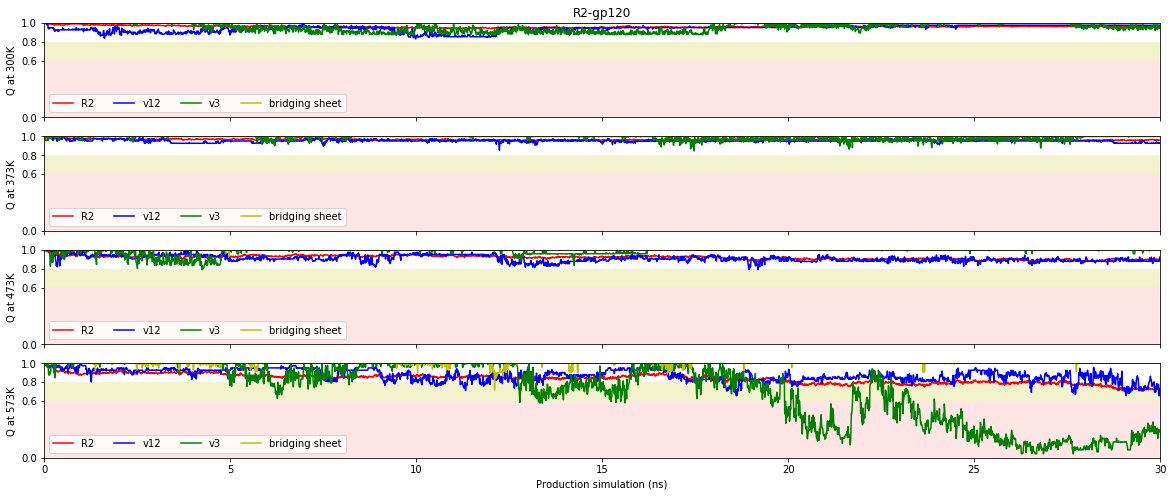

In [82]:
figure(figsize=(20,8))
for i,t in enumerate(temps): 
    plt.subplot(4,1,i+1)
    if i ==0:
        title('R2-gp120')
    plot(r2_q.iloc[i*3], 'r', label='R2')
    plot(r2_q_v12.iloc[i*3], 'b', label='v12')
    plot(r2_q_v3.iloc[i*3], 'g', label='v3')
    plot(r2_q_b.iloc[i*3], 'y', label='bridging sheet')
    fill_between(range(0,3000), 0.8, 0.6, facecolor='y', interpolate=True, alpha=0.2)
    fill_between(range(0,3000), 0.6, 0, facecolor='r', interpolate=True, alpha=0.1)
    xlim(0,3000)
    xticks([0,500,1000,1500,2000,2500,3000],[])
    ylim(0,1.0)
    ylabel('Q at '+t[:-1]+'K')
    yticks([0.0,0.6,0.8,1.0])
    legend(ncol=4,loc=3)
xticks([0,500,1000,1500,2000,2500,3000],['0','5','10','15','20','25','30'])
xlabel('Production simulation (ns)')
savefig('../imgs/fig 4/R2.png',dpi=480,bbox_inches="tight")

# unbound

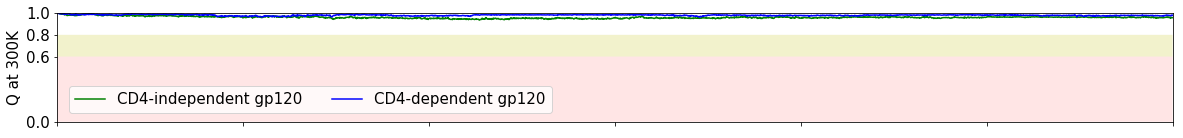

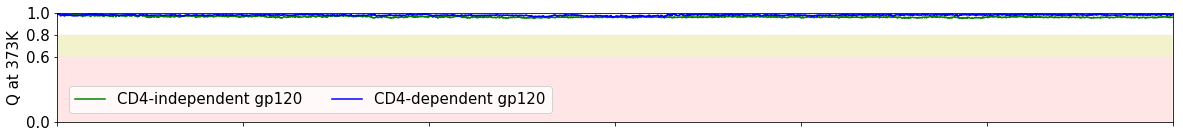

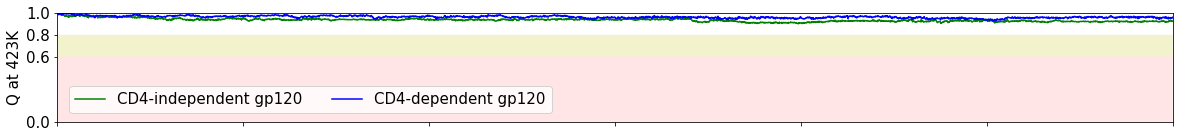

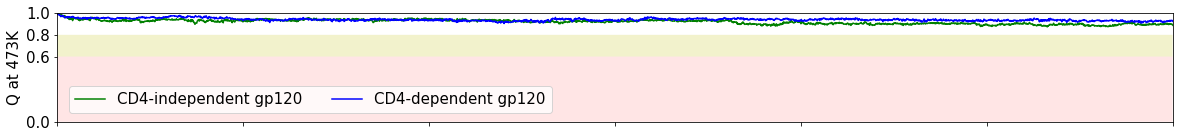

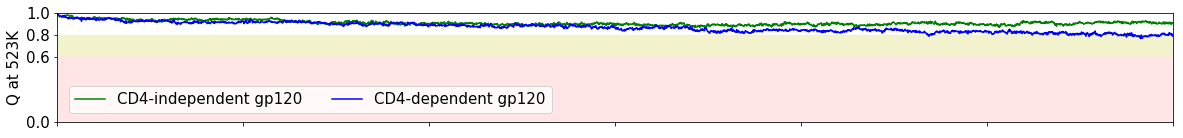

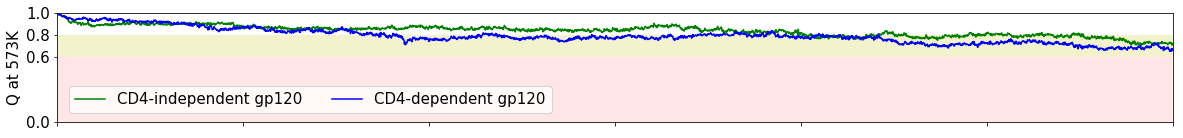

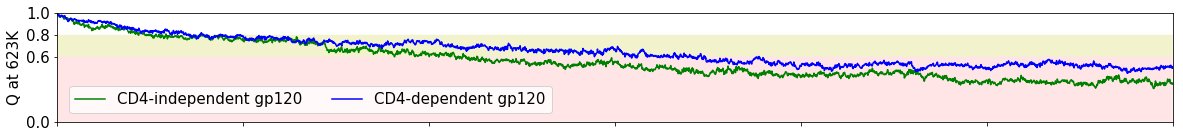

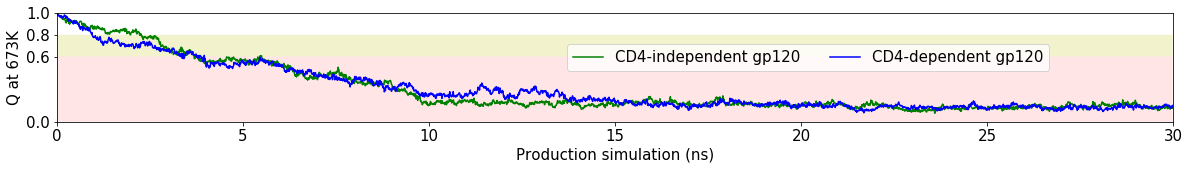

In [91]:
matplotlib.rcParams.update({'font.size': 15})
for i,t in enumerate(temps): 
    figure(figsize=(20,2))
    plot(r2_q.iloc[i], 'g', label='CD4-independent gp120')
    plot(h_q.iloc[i], 'b', label='CD4-dependent gp120')    
    fill_between(range(0,3000), 0.8, 0.6, facecolor='y', interpolate=True, alpha=0.2)
    fill_between(range(0,3000), 0.6, 0, facecolor='r', interpolate=True, alpha=0.1)
    xlim(0,3000)
    xticks([0,500,1000,1500,2000,2500,3000],[])
    ylim(0,1.0)
    ylabel('Q at '+t[:-1]+'K')
    yticks([0.0,0.6,0.8,1.0])
    legend(ncol=2, bbox_to_anchor=(0.45,0.4))
xticks([0,500,1000,1500,2000,2500,3000],['0','5','10','15','20','25','30'])
xlabel('Production simulation (ns)')

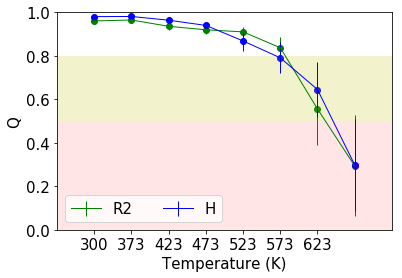

In [92]:
x = arange(0,len(temps))
scatter(x,r2_q.mean(axis=1), color='g')
errorbar(x,r2_q.mean(axis=1), yerr=r2_q.std(axis=1), color='g', linewidth=1, label='R2')
scatter(x,h_q.mean(axis=1), color='b')
errorbar(x,h_q.mean(axis=1), yerr=h_q.std(axis=1), color='b', linewidth=1, label='H')
xticks([0,1,2,3,4,5,6],['300','373','423','473','523','573','623'])
xlabel('Temperature (K)')
xlim(-1,len(temps))
fill_between(range(-1,len(temps)+1), 0.8, 0.5, facecolor='y', interpolate=True, alpha=0.2)
fill_between(range(-1,len(temps)+1), 0.5, 0, facecolor='r', interpolate=True, alpha=0.1)
ylim(0,1.0)
ylabel('Q')
legend(ncol=2)

In [80]:
h_q.to_csv('q/h_unbound_q.csv', index=False)
r2_q.to_csv('q/r2_unbound_q.csv', index=False)
# h_bound_q.to_csv('q/h_bound_q.csv', index=False)
# r2_bound_q.to_csv('q/r2_bound_q.csv', index=False)